In [15]:
import scipy.io
import scipy.misc
import numpy as np
import tensorflow as tf
from PIL import Image
import time
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
#from loss_utils import content_loss_calculate, style_loss_calculate
from utils.vgg_util import vgg_func, layers_and_mean
from utils.style_util import content_loss_calculate, style_loss_calculate,save_image
%matplotlib inline




# Style Transfer 

In this code, we are combining the content of one image with the style of another image, using the paper --A Neural Algorithm of Artistic Style (Gatys et al, 2015)
We are using already trained model - VGG19 to get the optimized weights and biases

In [16]:
#loading vgg19, and defining the paramater

#height and width of the images
height = 600
width = 600

# number of iterations
n = 2500
#alpha and beta for the loss
alpha = 5
beta = 5000
#
vgg = vgg_func(height,width)
layers, mean = layers_and_mean()
print(mean)


[123.68  116.779 103.939]


### Load content Image 

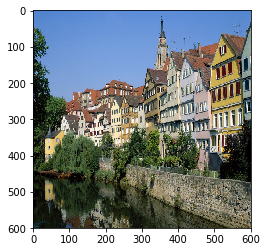

In [17]:
#loading and processing content image

c_img = Image.open("Data/Neckarfront.jpeg")
c_img = c_img.resize((width, height))
plt.imshow(c_img)

content_img = np.asarray(c_img, dtype='float32')
content_img = np.expand_dims(content_img, axis=0)

#normalizing the content image 
content_img -= mean


### Load Style Image

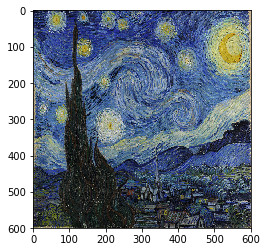

In [18]:
#loading and processing style image

s_img = Image.open('Data/The_Starry_Night.jpeg')
s_img = s_img.resize((width, height))
plt.imshow(s_img)
style_img = np.asarray(s_img, dtype='float32')
style_img = np.expand_dims(style_img, axis=0)

#normalizing the style image
style_img-=mean

### Define the output image using content image and noise

Here, we are defining the output image using the noise in the content image. Second output image will be used later in the extension to the model

In [19]:
# creating the output image 
noise = 0.6
noise_img = np.random.uniform(-10, 10,(1, height, width, 3)).astype('float32')
result_img = noise_img * noise + content_img * (1 - noise)
# we will use result_img_2 later for the second style output
result_img_2 = noise_img * noise + content_img * (1 - noise)


### Optimize the style and content loss to get the output Image

In [21]:
#Computing total loss, running optimizer to minimize loss at each iteration
loss_hist = []
start_time = time.time()
with tf.Session() as s:
    
    
    s.run(tf.global_variables_initializer())
    s.run(vgg['input'].assign(content_img))
    content_loss = content_loss_calculate(s, vgg)

  
    s.run(vgg['input'].assign(style_img))
    style_loss = style_loss_calculate(s, vgg)
    
    
    loss = alpha * content_loss + beta * style_loss
    optimizer = tf.train.AdamOptimizer(2.0)
    image_t = optimizer.minimize(loss)
    
    s.run(tf.global_variables_initializer())
    s.run(vgg['input'].assign(result_img))
    for i in range(n):
        s.run(image_t)
        if (i%50==0):
            result_img= s.run(vgg['input'])
            l = s.run(loss)
            print('Iteration:{} loss: {}'.format(i, l))
            loss_hist.append(l)
            
duration = time.time() - start_time
print("=======================")
print('Running Time {}'.format(duration))

Iteration:0 loss: 4998107758592.0
Iteration:50 loss: 113485873152.0
Iteration:100 loss: 45765230592.0
Iteration:150 loss: 27583612928.0
Iteration:200 loss: 18713249792.0
Iteration:250 loss: 13655707648.0
Iteration:300 loss: 10550737920.0
Iteration:350 loss: 8512143872.0
Iteration:400 loss: 7089145856.0
Iteration:450 loss: 6042913280.0
Iteration:500 loss: 5239353344.0
Iteration:550 loss: 4601949184.0
Iteration:600 loss: 4081844736.0
Iteration:650 loss: 3648365568.0
Iteration:700 loss: 3280868608.0
Iteration:750 loss: 2967208448.0
Iteration:800 loss: 2696377600.0
Iteration:850 loss: 2460284928.0
Iteration:900 loss: 2253461760.0
Iteration:950 loss: 2071141888.0
Iteration:1000 loss: 1909761408.0
Iteration:1050 loss: 1766334592.0
Iteration:1100 loss: 1637996672.0
Iteration:1150 loss: 1522542080.0
Iteration:1200 loss: 1418981120.0
Iteration:1250 loss: 1325856640.0
Iteration:1300 loss: 1241710976.0
Iteration:1350 loss: 1165436672.0
Iteration:1400 loss: 1096082944.0
Iteration:1450 loss: 130338

###  Plot the total loss 

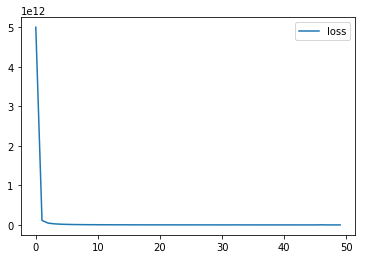

In [23]:
#showing the loss
plt.plot(loss_hist, label="loss")
plt.legend()
plt.show()


### Save and Display the output Image : Content + Style

In [27]:
 
def save_image(img, i,type):
    shape = img.shape
    k_img = np.reshape(img, (shape[1],shape[2],shape[3]))
    output_img2 = k_img + mean
    output_img3 = np.clip(output_img2,0, 255).astype('uint8')
    name = 'output' + str(i) + "_"+ str(type)+'.png'
    scipy.misc.imsave(name, output_img3)
    
    return output_img3

/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


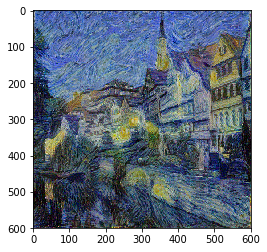

In [29]:
output_img = save_image(result_img, i,1)
imshow(output_img)

# Extension to the model 

## Style Transfer of Two Images 

Now, we added another style image in order to join style transfer of two images with one content image. The process is similar to the one used before. However, we added a new weight (beta_2) to the second style to include its influence in the result image. 

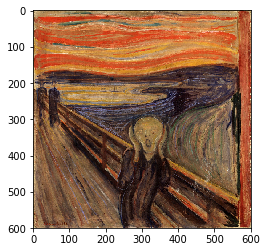

In [31]:
# Second Style Image 
s_2_img = Image.open("Data/Der_Schrie.jpg")
s_2_img = s_2_img.resize((width, height))
plt.imshow(s_2_img)
style_img_2 = np.asarray(s_2_img, dtype='float32')
style_img_2 = np.expand_dims(style_img_2, axis=0)
style_img_2-=mean


We assign less weight to the second style image to reflect its reduced effect in the output image

In [32]:
# weights defined for both the images
beta_1 = beta  # 2500
beta_2 = beta/2

We used a different formula for total loss, including the style loss of the second style image along with its weight in the formula we used before 

$$ Total Loss = Weight_{content}* Loss_{content} + Weight_{style1}* Loss_{style1} + Weight_{style2} * Loss_{style2} $$

In [34]:
# optimize the total loss

loss_hist1 = []

# to save the images at mutiple points, we are using this list
breaks = [10, 50, 250,500,1000]
with tf.Session() as s:
    
    s.run(tf.global_variables_initializer())
    
    s.run(vgg['input'].assign(content_img))
    content_loss = content_loss_calculate(s, vgg)

    
    s.run(vgg['input'].assign(style_img))
    style_loss = style_loss_calculate(s, vgg)
    
    s.run(vgg['input'].assign(style_img_2))
    style_loss_2 = style_loss_calculate(s, vgg)
    
    #New function for the total loss
    loss = alpha * content_loss + beta_1 * style_loss + beta_2 * style_loss_2

    optimizer = tf.train.AdamOptimizer(2.0)
    image_t = optimizer.minimize(loss)
    
    s.run(tf.global_variables_initializer())
    s.run(vgg['input'].assign(result_img_2))
          
    for i in range(n):
        s.run(image_t)
        if (i%50==0):
            result_img_2= s.run(vgg['input'])
            l = s.run(loss)
            print('Iteration:{} loss: {}'.format(i, l))
            loss_hist1.append(l)
        if i in breaks:
             save_image(result_img_2,i,2)
            

Iteration:0 loss: 8425538846720.0


/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration:50 loss: 1975846567936.0
Iteration:100 loss: 1871038382080.0
Iteration:150 loss: 1841092231168.0
Iteration:200 loss: 1826423832576.0
Iteration:250 loss: 1817877938176.0
Iteration:300 loss: 1812454965248.0
Iteration:350 loss: 1808812998656.0
Iteration:400 loss: 1806245036032.0
Iteration:450 loss: 1804348948480.0
Iteration:500 loss: 1802894704640.0
Iteration:550 loss: 1801744547840.0
Iteration:600 loss: 1800809873408.0
Iteration:650 loss: 1800034189312.0
Iteration:700 loss: 1799378960384.0
Iteration:750 loss: 1798817185792.0
Iteration:800 loss: 1798329335808.0
Iteration:850 loss: 1797901516800.0
Iteration:900 loss: 1797523374080.0
Iteration:950 loss: 1797187436544.0
Iteration:1000 loss: 1796886888448.0
Iteration:1050 loss: 1796617535488.0
Iteration:1100 loss: 1796375052288.0
Iteration:1150 loss: 1796156162048.0
Iteration:1200 loss: 1796252762112.0
Iteration:1250 loss: 1795788636160.0
Iteration:1300 loss: 1795843686400.0
Iteration:1350 loss: 1795484549120.0
Iteration:1400 loss: 

### Plot the resultant of the Image generated using two styles

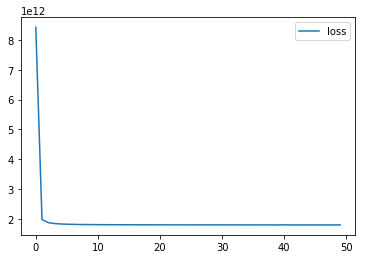

In [35]:
#plotting the loss
plt.plot(loss_hist1, label="loss")
plt.legend()
plt.show()

###  Display the Image generated using two Styles

/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


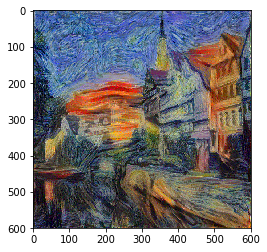

In [37]:
output_img_2 = save_image(result_img_2, i, 1)
imshow(output_img_2)